### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [ ]:
print("Всем удачи!👒 Тут она точно пригодится.")

Всем удачи!👒 Тут она точно пригодится.


In [ ]:
%pylab inline
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import time
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from collections import defaultdict
import random
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tqdm import tqdm

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator


class LogReg(BaseEstimator):
    def __init__(
        self,
        gd_type="stochastic",
        tolerance=1e-4,
        max_iter=1000,
        w0=None,
        eta=1e-2,
        size=None,
        seed=None,
        l1_ratio=None,
    ):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = (
            None  # list of loss function values at each training iteration
        )
        self.size = size
        self.seed = seed
        self.l1_ratio = l1_ratio

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        if self.w0 is None:
            self.w0 = np.random.rand(X.shape[1])
        self.w = self.w0.copy()

        for _ in range(self.max_iter):
            gradient = self.calc_gradient(X, y)
            self.w = self.w - self.eta * gradient
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(self.eta * gradient) < self.tolerance:
                break

        return self

    def predict_proba(self, X):
        if self.w is None:
            raise Exception("Not trained yet")
        return 1 / (1 + np.exp(-(X @ self.w)))

    def predict(self, X):
        if self.w is None:
            raise Exception("Not trained yet")
        return np.round(self.predict_proba(X))

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        if self.gd_type == "stochastic":
            if self.size is None:
                self.size = 1
            ind = np.random.choice(X.shape[0], size=self.size)
            X_ind = X.values[ind]
            y_ind = y[ind]
            predictions = self.predict_proba(X_ind)
            gradient = 2.0 / len(y_ind) * (X_ind.T @ (predictions - y_ind))
        else:
            predictions = self.predict_proba(X)
            gradient = 2.0 / len(y) * (X.T @ (predictions - y))

        if self.l1_ratio is not None:
            gradient += self.l1_ratio * np.sign(self.w)

        return gradient

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        predictions = self.predict_proba(X)
        epsilon = 1e-5
        loss = -np.mean(
            y.T * np.log(predictions + epsilon)
            + (1 - y).T * np.log(1 - predictions + epsilon)
        )
        return loss

Синтетические данные

In [ ]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [ ]:
def measure_time(model, X, y, X_test, y_test):
    """
    Оценка качества модели, времени обучения и предсказания.
    """
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    train_time = end_time - start_time

    # Предсказание на train
    y_pred_train = model.predict(X)
    accuracy_train = accuracy_score(y, y_pred_train)

    # Предсказание на test
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    predict_time = end_time - start_time
    accuracy_test = accuracy_score(y_test, y_pred)

    return train_time, predict_time, accuracy_train, accuracy_test

In [ ]:
lr_full = LogReg(gd_type="full", max_iter=1000, tolerance=1e-6, eta=0.01, seed=0)
train_time, predict_time, accuracy_train, accuracy_test = measure_time(
    lr_full, X_train, y_train, X_test, y_test
)

In [ ]:
print(
    f"Доля правильных ответов на тренировочных даннных для логистической регрессии на градиентном спуске: {accuracy_train:.2f}"
)
print(f"Время обучения: {train_time:.4f} сек.")
print(f"Доля правильных ответов на тестовых данных: {accuracy_test:.2f}")
print(f"Время предсказания: {predict_time:.4f} сек.\n")

Доля правильных ответов на тренировочных даннных для логистической регрессии на градиентном спуске: 0.85
Время обучения: 8.8405 сек.
Доля правильных ответов на тестовых данных: 0.85
Время предсказания: 0.0009 сек.



In [ ]:
lr_stochastic = LogReg(
    gd_type="stochastic", max_iter=2000, tolerance=1e-8, eta=0.01, size=1, seed=0
)
train_time, predict_time, accuracy_train, accuracy_test = measure_time(
    lr_stochastic, pd.DataFrame(X_train), y_train, X_test, y_test
)

In [ ]:
print(
    f"Доля правильных ответов на тренировочных даннных для логистической регрессии на стохастическом градиентном спуске: {accuracy_train:.2f}"
)
print(f"Время обучения: {train_time:.4f} сек.")
print(f"Доля правильных ответов на тестовых данных: {accuracy_test:.2f}")
print(f"Время предсказания: {predict_time:.4f} сек.\n")

Доля правильных ответов на тренировочных даннных для логистической регрессии на стохастическом градиентном спуске: 0.77
Время обучения: 0.1691 сек.
Доля правильных ответов на тестовых данных: 0.76
Время предсказания: 0.0009 сек.



На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [ ]:
def compute_metrics_and_curve(model, X, y):
    y_prob = model.predict_proba(X)
    roc_auc = roc_auc_score(y, y_prob)
    precision, recall, _ = precision_recall_curve(y, y_prob)
    pr_auc = auc(recall, precision)
    fpr, tpr, _ = roc_curve(y, y_prob)
    return roc_auc, pr_auc, fpr, tpr, precision, recall


def plot_curve(ax, fpr, tpr, precision, recall, roc_auc, pr_auc, method):
    ax.plot(fpr, tpr, label=f"ROC кривая (AUC = {roc_auc:.2f})")
    ax.set_xlabel("FPR" if method == "roc" else "Recall")
    ax.set_ylabel("TPR" if method == "roc" else "Precision")
    ax.set_title(f"ROC - кривая" if method == "roc" else f"PR - кривая")
    ax.legend(loc="lower right")

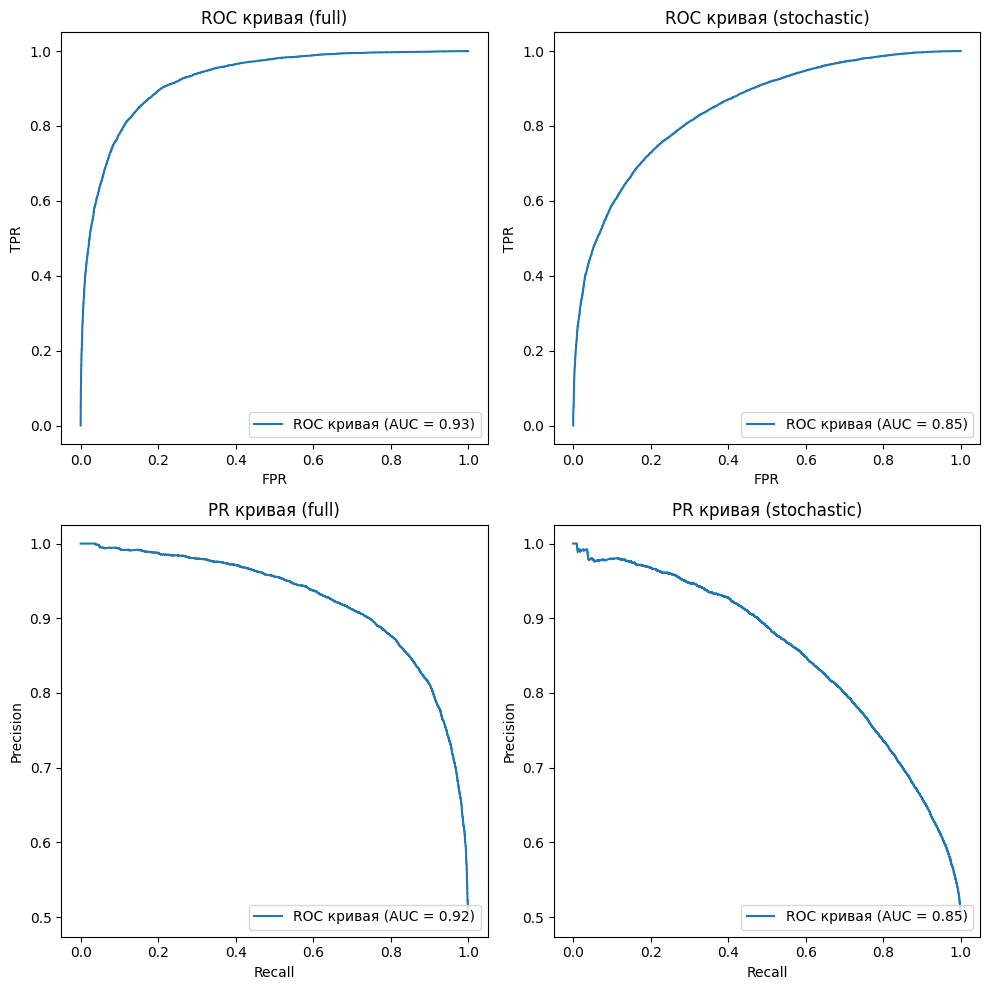

In [ ]:
model_list = [lr_full, lr_stochastic]
method_list = ["full", "stochastic"]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (model, method) in enumerate(zip(model_list, method_list)):
    roc_auc, pr_auc, fpr, tpr, precision, recall = compute_metrics_and_curve(
        model, X_test, y_test
    )
    plot_curve(axes[0][i], fpr, tpr, precision, recall, roc_auc, pr_auc, "roc")
    plot_curve(axes[1][i], recall, precision, precision, recall, pr_auc, roc_auc, "pr")
    axes[0][i].set_title(f"ROC кривая ({method})")
    axes[1][i].set_title(f"PR кривая ({method})")

plt.tight_layout()
plt.show()

Ответ: Подобрав оптимальные гиперпараметры для обучения градиентного и стохастического градиентного спуска получили результат качества модели - хуже, но практически сопоставимый, однако время обучения снизилась в два раза (важно правильно настроить гиперпараметры, тогда качество сойдется). Можно еще попробовать использовать пакетный стохастический градиентный спуск, он более стабильный по дисперсии в направлении градиента. И возможно им получиться так же поднять качество, при этом не потеряв во времени обучения.

Большие и резкие скачки (колебания) на PR кривой в начале графика возникают ввиду хаотичного выбора одного объекта данных, по которому идет обновление весов. Это в свою очередь связано с шумами и неоднародностью в данных. Как следствие градиенты по отдельным объектам имеют большую дисперсию, и могут меняться слишком быстро что приводит к колебаниям.

Для решения этой проблемы, как было сказано выше, лучше использовать пакетный выбор данных, в место выбора одного объекта. Данные не плохо было бы стандартизировать, в алгоритм добавить регуляризации, рассмотреть варианты с адаптивными спусками, подобрать качественно гиперпараметры на кросс-валидации.

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [ ]:
!gdown 1A1hqkdZlzZmdg6MXFzcLO31QxpQUDJx3
!unzip train.csv.zip
!rm train.csv.zip

Downloading...
From (original): https://drive.google.com/uc?id=1A1hqkdZlzZmdg6MXFzcLO31QxpQUDJx3
From (redirected): https://drive.google.com/uc?id=1A1hqkdZlzZmdg6MXFzcLO31QxpQUDJx3&confirm=t&uuid=8417e730-442a-44be-a5d8-0c361246ee62
To: /content/train.csv.zip
100% 31.4M/31.4M [00:00<00:00, 38.1MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
data = pd.read_csv("train.csv", index_col=0)
target = data.target.values
data = data.drop("target", axis=1)

In [ ]:
data.head(3)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
9,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
13,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0


Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [ ]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [ ]:
def get_auc(model, X, y, X_test, y_test):
    model.fit(X, y)

    y_proba = model.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_proba)

    return print(f"ROC-AUC на тестовых данных: {auc_score}")

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(lr, X_train, y_train, X_test, y_test)

ROC-AUC на тестовых данных: 0.5079697547147645
CPU times: user 1.91 s, sys: 2.67 s, total: 4.57 s
Wall time: 3.43 s


In [ ]:
X_train.shape[1]

57

**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [ ]:
cat_cols = X_train.filter(like="cat", axis=1).columns

In [ ]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [ ]:
ohe = OneHotEncoder(drop="first", sparse_output=False).set_output(transform="pandas")

transformed_train = ohe.fit_transform(X_train_ohe[cat_cols])
transformed_test = ohe.transform(X_test_ohe[cat_cols])

X_train_ohe = pd.concat([X_train_ohe, transformed_train], axis=1)
X_train_ohe.drop(cat_cols, axis=1, inplace=True)

X_test_ohe = pd.concat([X_test_ohe, transformed_test], axis=1)
X_test_ohe.drop(cat_cols, axis=1, inplace=True)

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(lr, X_train_ohe, y_train, X_test_ohe, y_test)

ROC-AUC на тестовых данных: 0.5623660848980716
CPU times: user 1min 28s, sys: 2min 34s, total: 4min 3s
Wall time: 2min 24s


In [ ]:
X_train_ohe.shape[1]

212

Качество модели подросло, время выполения кода увеличилось значительно.

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [ ]:
X_train_counts = X_train.copy()
X_test_counts = X_test.copy()

In [ ]:
for ind in cat_cols:
    cat_dict = defaultdict(int)
    for x_train_val, y_train_val in zip(X_train[ind], y_train):
        if y_train_val == 1:
            cat_dict[x_train_val] += 1

    for cat, count in cat_dict.items():
        cat_val = count / np.sum(X_train[ind] == cat)
        X_train_counts.loc[X_train[ind] == cat, ind] = cat_val
        X_test_counts.loc[X_test[ind] == cat, ind] = cat_val

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(lr, X_train_counts, y_train, X_test_counts, y_test)

ROC-AUC на тестовых данных: 0.5496350583147449
CPU times: user 31.4 s, sys: 45.4 s, total: 1min 16s
Wall time: 44 s


In [ ]:
X_train_counts.shape[1]

57

Время обучения с предсказанием значительно не повысилось, по сравнению с исходной моделью без кодирования. Однако качество стало лучше, сопоставимо с качеством при кодировании методом OHE.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [ ]:
X_train_counts = X_train.copy()
X_test_counts = X_test.copy()

In [ ]:
def add_noise(value):
    return value + random.uniform(-0.01, 0.01)


for ind in cat_cols:
    cat_dict = defaultdict(int)
    for x_train_val, y_train_val in zip(X_train[ind], y_train):
        if y_train_val == 1:
            cat_dict[x_train_val] += 1

    for cat, count in cat_dict.items():
        cat_val = count / np.sum(X_train[ind] == cat)
        cat_val_with_noise = add_noise(cat_val)
        X_train_counts.loc[X_train[ind] == cat, ind] = cat_val_with_noise
        X_test_counts.loc[X_test[ind] == cat, ind] = cat_val_with_noise

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(lr, X_train_counts, y_train, X_test_counts, y_test)

ROC-AUC на тестовых данных: 0.5763188662989916
CPU times: user 31.7 s, sys: 46 s, total: 1min 17s
Wall time: 44.2 s


Время обучения и предсказания осталось преждним, как и для счетчика без зашумленности, метрика качества немного подросла.

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [ ]:
data = pd.read_csv("train.csv", index_col=0)
target = data.target.values
data = data.drop("target", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=124
)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
cat_cols = X_train.filter(like="cat", axis=1).columns

In [ ]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

In [ ]:
ohe = OneHotEncoder(drop="first", sparse_output=False).set_output(transform="pandas")

transformed_train = ohe.fit_transform(X_train_ohe[cat_cols])
transformed_test = ohe.transform(X_test_ohe[cat_cols])

X_train_ohe = pd.concat([X_train_ohe, transformed_train], axis=1)
X_train_ohe.drop(cat_cols, axis=1, inplace=True)

X_test_ohe = pd.concat([X_test_ohe, transformed_test], axis=1)
X_test_ohe.drop(cat_cols, axis=1, inplace=True)

In [ ]:
print(f"Число признаков до кодирования OHE: {X_train.shape[1]}")
print(f"Число признаков после кодирования OHE: {X_train_ohe.shape[1]}")

Число признаков до кодирования OHE: 57
Число признаков после кодирования OHE: 213


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(lr, X_train_ohe, y_train, X_test_ohe, y_test)

ROC-AUC на тестовых данных: 0.5263551609850202
CPU times: user 34.8 s, sys: 38.3 s, total: 1min 13s
Wall time: 59.4 s


### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [ ]:
impotrant_features_200 = [
    col[1] for col in sorted(list(zip(abs(lr.w), X_train_ohe.columns)), reverse=True)
][:200]

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(
    lr,
    X_train_ohe[impotrant_features_200],
    y_train,
    X_test_ohe[impotrant_features_200],
    y_test,
)

ROC-AUC на тестовых данных: 0.5248556867783711
CPU times: user 37.8 s, sys: 41.8 s, total: 1min 19s
Wall time: 1min 4s


Качество осталось на прежднем уровне. Конечно, правильно было бы усреднять результат на нескольких итераций. Но на данном этапе ограничимся единственным запуском.

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
cols = X_train_ohe.columns

scaler = StandardScaler()

X_train_ohe_scaler = scaler.fit_transform(X_train_ohe)
X_test_ohe_scaler = scaler.transform(X_test_ohe)

X_train_ohe_scaler = pd.DataFrame(X_train_ohe_scaler, columns=cols)
X_test_ohe_scaler = pd.DataFrame(X_test_ohe_scaler, columns=cols)

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(lr, X_train_ohe_scaler, y_train, X_test_ohe_scaler, y_test)

ROC-AUC на тестовых данных: 0.4979580837217104
CPU times: user 2min 27s, sys: 28.4 s, total: 2min 55s
Wall time: 1min 41s


In [ ]:
impotrant_features_200 = [
    col[1]
    for col in sorted(list(zip(abs(lr.w), X_train_ohe_scaler.columns)), reverse=True)
][:200]

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(
    lr,
    X_train_ohe_scaler[impotrant_features_200],
    y_train,
    X_test_ohe_scaler[impotrant_features_200],
    y_test,
)

ROC-AUC на тестовых данных: 0.512051648467246
CPU times: user 2min 20s, sys: 28.3 s, total: 2min 48s
Wall time: 1min 37s


In [ ]:
# lr.w

В данном примере качество модели немного уупало с уменьшением числа менее важных признаков. Время обучения и предсказания прежднее.

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [ ]:
lr = LogReg(
    gd_type="stochastic",
    max_iter=1000,
    tolerance=1e-5,
    eta=0.01,
    size=5,
    seed=0,
    l1_ratio=1,
)

In [ ]:
%%time
get_auc(lr, X_train_ohe_scaler, y_train, X_test_ohe_scaler, y_test)

ROC-AUC на тестовых данных: 0.5078738665318716
CPU times: user 2min 26s, sys: 27.8 s, total: 2min 54s
Wall time: 1min 39s


In [ ]:
# lr.w

Результат стал хуже, веса не занулились, но стали меньше. Необходимо подобрать альфа более точно по сетке. Воспользуемся библиотечной реализацией.

Используем библиотечную реализацию для ускорения подбора alpha. Но так как данных и признаков очень много, у меня код работает долго.

In [ ]:
# lr = LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', solver='liblinear')
# alphas = np.linspace(0.01, 2, num=50)

# param_grid = {'C': 1 / np.array(alphas)}
# grid_search = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, error_score='raise')
# grid_search.fit(X_train_ohe_scaler, y_train)

# best_alpha = 1 / grid_search.best_params_['C']
# print("Лучшая Alpha:", best_alpha)
# print("Лучшая ROC-AUC:", grid_search.best_score_)

# best_model = grid_search.best_estimator_
# y_pred_proba = best_model.predict_proba(X_test_ohe_scaler)[:, 1]
# test_roc_auc = roc_auc_score(y_test, y_pred_proba)
# print("Test ROC-AUC лучшая Alpha:", test_roc_auc)

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен.

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
def calculate_t_statistic(X, y):
    X_pos = X[y == 1]
    X_neg = X[y == 0]

    mu_pos, mu_neg = np.mean(X_pos, axis=0), np.mean(X_neg, axis=0)
    sigma_pos, sigma_neg = np.std(X_pos, axis=0), np.std(X_neg, axis=0)

    n_pos, n_neg = len(X_pos), len(X_neg)

    numerator = np.abs(mu_pos - mu_neg)
    denominator = np.sqrt(
        ((n_pos - 1) * sigma_pos**2 + (n_neg - 1) * sigma_neg**2) / (n_pos + n_neg - 2)
    )  # ddof=1
    t_statistic = numerator / denominator

    top_indices = np.argsort(t_statistic)[::-1]

    return top_indices

In [ ]:
top_indices = calculate_t_statistic(X_train_ohe_scaler, y_train)
top_indices_200 = top_indices[:200].index

In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(
    lr,
    X_train_ohe_scaler[top_indices_200],
    y_train,
    X_test_ohe_scaler[top_indices_200],
    y_test,
)

ROC-AUC на тестовых данных: 0.5081070212450547
CPU times: user 2min 19s, sys: 28.2 s, total: 2min 47s
Wall time: 1min 37s


Качество упало, по сравнению с результатом в случае с отбором признаков по величине весов.

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
X_train_ohe_scaler.shape, X_test_ohe_scaler.shape, y_train.shape, y_test.shape

((476169, 213), (119043, 213), (476169,), (119043,))

In [ ]:
sample_size = 10000

indexes = (
    X_train_ohe_scaler.reset_index(drop=True).sample(sample_size, random_state=0).index
)

X_train_wrap = X_train_ohe_scaler.iloc[indexes]
y_train_wrap = [y_train[i] for i in indexes]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_wrap, y_train_wrap, test_size=0.3, random_state=42
)

In [ ]:
batch_size = 1

feature_groups = [
    list(X_train_split.columns[i : i + batch_size])
    for i in range(0, len(X_train_split.columns), batch_size)
]

In [ ]:
def calc_worst_features(X_train, X_val, y_train, y_val, feature_groups):
    best_auc = 0
    worst_removed_features = []

    for features_to_remove in tqdm(
        feature_groups, desc="Жадный поиск по всем признакам"
    ):
        X_train_subset = X_train.drop(features_to_remove, axis=1)
        X_val_subset = X_val.drop(features_to_remove, axis=1)

        model = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=0)
        model.fit(X_train_subset, y_train)
        y_pred_proba = model.predict_proba(X_val_subset)[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)

        if auc > best_auc:
            best_auc = auc
            worst_removed_features = features_to_remove

    return worst_removed_features, best_auc

In [ ]:
# %%time
# calc_worst_features(X_train_split, X_val_split, y_train_split, y_val_split, feature_groups)

In [ ]:
def create_new_batches(data, batch_size):
    flat_data = []

    for sublist in data:
        flat_data.extend(sublist)

    batches = [flat_data[i : i + batch_size] for i in range(0, len(data), batch_size)]

    return batches

In [ ]:
%%time

current_feature_groups = feature_groups.copy()

while len([feature for group in current_feature_groups for feature in group]) > 200:
    worst_removed_features, auc = calc_worst_features(
        X_train_split, X_val_split, y_train_split, y_val_split, current_feature_groups
    )

    current_feature_groups.remove(worst_removed_features)
    feature_groups = create_new_batches(feature_groups, batch_size)

    print(f"AUC: {auc}, без признаков: {worst_removed_features}")
    pass

Жадный поиск по всем признакам: 100%|██████████| 213/213 [00:59<00:00,  3.57it/s]


AUC: 0.6057528377226435, без признаков: ['ps_car_11_cat_96']


Жадный поиск по всем признакам: 100%|██████████| 212/212 [01:00<00:00,  3.50it/s]


AUC: 0.6049620889227871, без признаков: ['ps_car_11_cat_61']


Жадный поиск по всем признакам: 100%|██████████| 211/211 [01:01<00:00,  3.45it/s]


AUC: 0.6043255641796401, без признаков: ['ps_car_04_cat_6']


Жадный поиск по всем признакам: 100%|██████████| 210/210 [00:59<00:00,  3.51it/s]


AUC: 0.6039582305172956, без признаков: ['ps_car_11_cat_23']


Жадный поиск по всем признакам: 100%|██████████| 209/209 [01:01<00:00,  3.42it/s]


AUC: 0.6031702857911974, без признаков: ['ps_car_11_cat_100']


Жадный поиск по всем признакам: 100%|██████████| 208/208 [00:58<00:00,  3.58it/s]


AUC: 0.6029655884068376, без признаков: ['ps_car_11_cat_67']


Жадный поиск по всем признакам: 100%|██████████| 207/207 [01:04<00:00,  3.19it/s]


AUC: 0.6020430481403383, без признаков: ['ps_car_06_cat_6']


Жадный поиск по всем признакам: 100%|██████████| 206/206 [00:57<00:00,  3.57it/s]


AUC: 0.6018551751985284, без признаков: ['ps_car_01_cat_5']


Жадный поиск по всем признакам: 100%|██████████| 205/205 [00:58<00:00,  3.48it/s]


AUC: 0.6018243303871865, без признаков: ['ps_calc_07']


Жадный поиск по всем признакам: 100%|██████████| 204/204 [00:58<00:00,  3.49it/s]


AUC: 0.6017990937233614, без признаков: ['ps_car_11_cat_82']


Жадный поиск по всем признакам: 100%|██████████| 203/203 [00:57<00:00,  3.54it/s]


AUC: 0.6015270985688007, без признаков: ['ps_car_11_cat_73']


Жадный поиск по всем признакам: 100%|██████████| 202/202 [00:57<00:00,  3.52it/s]


AUC: 0.601291556373099, без признаков: ['ps_car_04_cat_9']


Жадный поиск по всем признакам: 100%|██████████| 201/201 [00:57<00:00,  3.51it/s]

AUC: 0.6007699986540446, без признаков: ['ps_car_11_cat_26']
CPU times: user 16min 51s, sys: 5min 3s, total: 21min 54s
Wall time: 12min 52s


In [ ]:
best_features = [feature for group in current_feature_groups for feature in group]

In [ ]:
print(
    f"Лучший результат AUC на тестовых данных при числе признаков: {len(best_features)}, составил: {auc}"
)

Лучший результат AUC на тестовых данных при числе признаков: 200, составил: 0.6007699986540446


In [ ]:
lr = LogReg(
    gd_type="stochastic", max_iter=1000, tolerance=1e-5, eta=0.01, size=5, seed=0
)

In [ ]:
%%time
get_auc(
    lr,
    X_train_ohe_scaler[best_features],
    np.array(y_train),
    X_test_ohe_scaler[best_features],
    np.array(y_test),
)

ROC-AUC на тестовых данных: 0.49268034241098996
CPU times: user 2min 19s, sys: 28 s, total: 2min 47s
Wall time: 1min 38s


Время обучения заметно снизилось, качество стало хуже относительно метода отбора признаков по весам модели. Вероятнее всего данный метод показал бы наилучшее качество используя все данные без разбития на пакеты в моменте отбора признаков.

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** ...

__Встроенные методы__

- Отбор признаков происходит исходя из 'мнения' рассматриваемой модели. Тем самым можно оценить как модель взаимодействует с признаками. Но не всегда это взаимодействие может быть оптимальным, как следствие может произойти игнорирование важных признаков;
- ROC-AUC на тестовых данных используя 200 наиболее значимых признаков, определенных по наибольшим весам: `0.512`;
- ROC-AUC на тестовых данных используя L1 регуляризацию: `0.507`.


__Методы фильтрации__

- Быстрота использования метода, т.к оценка признаков происходит в не зависимости от модели;
- Простота интерпретации результатов.
- Из недостатков - отстутствие связи взаимосдействия признаков с конкретной моделью;
- ROC-AUC на тестовых данных используя 200 наиболее важных признаков в соответствии с t-статистикой: `0.508`
- Так же можно мопробовать провести корреляционный анализ, вариационный анализ на основе критерия значимости, оценить взаимную информацию на основе критерия Фишера.


__Методы обертки__

- Учитывают взаимодействие между признаками и моделью;
- Высокая вычислительная сложность при большом количестве признаков;
- Риск переобучения.

- ROC-AUC при рекурсивном переборе (RFE) на части данных с признаками сгруппированными по пакетам: `0.493`.
Причиной низкого результата служит не показательнось выборочных данных и использование пакетов в которые попадают как важные так и не очень признаки.

В целом, каждый метод имеет свои преимущества и недостатки, и выбор метода зависит от таких факторов, как вычислительные ресурсы, сложность набора данных и конкретные цели выбора признаков. В этом случае встроенный метод с использованием 200 наиболее важных признаков по мнению модели дал наивысший результат по ROC-AUC, что указывает на его эффективность в данном случае.